Performance Analysis


In [31]:
import os
import string
import random
import paramiko
import pandas as pd
import numpy as np
from scp import SCPClient
from posixpath import join
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

run_id = 1
n_reducers = 3
methods = ['combiner', 'inmappercombiner']

jar_name = 'letter-frequency-1.0-SNAPSHOT.jar'
root_dir = '/user/hadoop/performance_analysis'

1. generate text files with random letters for performance analysis

In [ ]:
# file size in bytes
sizes = [10 * 1024, 1 * 1024 * 1024, 100 * 1024 * 1024, 1 * 1024 * 1024 * 1024]
chunk_size = 100 

# file names
input_dir = '../resources/performance_analysis/input'
filenames = [os.path.join(input_dir, "10KB.txt"), 
             os.path.join(input_dir, "1MB.txt"), 
             os.path.join(input_dir, "100MB.txt"), 
             os.path.join(input_dir, "1GB.txt")]

# generate a string of random letters
def generate_random_string(length):
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(length))

for size, filename in zip(sizes, filenames):
    print(f"Generating {filename}...")
    with open(filename, 'w') as f:
        for _ in range(size // chunk_size):
            f.write(generate_random_string(chunk_size))
            f.write('\n')
        remaining = size % chunk_size
        if remaining:
            f.write(generate_random_string(remaining))
    print(f"File {filename} generated successfully.")

2. for each combination of method and number of reducers, run the application for each text file

In [ ]:
# connect with ssh
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.1.1.124', username='hadoop', password='ubuntu')

# try all the combinations of methods and reducers
for method in methods:
    for i in range(1, n_reducers+1):
        for txt_file in os.listdir('../resources/performance_analysis/input'):
            print(f'Processing {txt_file} with {method} and {i} reducers')
            input_dir = join(root_dir, 'input', txt_file)
            output_dir = join(root_dir, f'output_{run_id}_{method}_{i}', txt_file.split('.')[0])
            ssh.exec_command(f'mkdir -p output_{run_id}_{method}_{i}/{txt_file.split(".")[0]}')

            stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp '
                                                     f'{input_dir} {output_dir}/count {output_dir}/freq {i} {method} '
                                                     f'> log.txt 2>&1')
            print(stderr.read().decode('utf-8'))
            
            # copy from hdfs to virtual machine
            stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal {output_dir} output_{run_id}_{method}_{i}/{txt_file.split(".")[0]}' )
            print(stderr.read().decode('utf-8'))
            stdin, stdout, stderr = ssh.exec_command(f'mv log.txt output_{run_id}_{method}_{i}/{txt_file.split(".")[0]}/log.txt')
            print(stderr.read().decode('utf-8'))
            
        # copy from virtual machine to local machine
        if not os.path.exists(f'../resources/performance_analysis/output_{run_id}_{method}_{i}'):
            os.mkdir(f'../resources/performance_analysis/output_{run_id}_{method}_{i}')
        scp = SCPClient(ssh.get_transport())
        scp.get(f'output_{run_id}_{method}_{i}', '../resources/performance_analysis/', recursive=True)
        
        # remove the output from virtual machine
        stdin, stdout, stderr = ssh.exec_command(f'rm -r output_{run_id}_{method}_{i}')
        print(stderr.read().decode('utf-8'))

scp.close()
ssh.close()

3. plot the results for a specific list of parameters

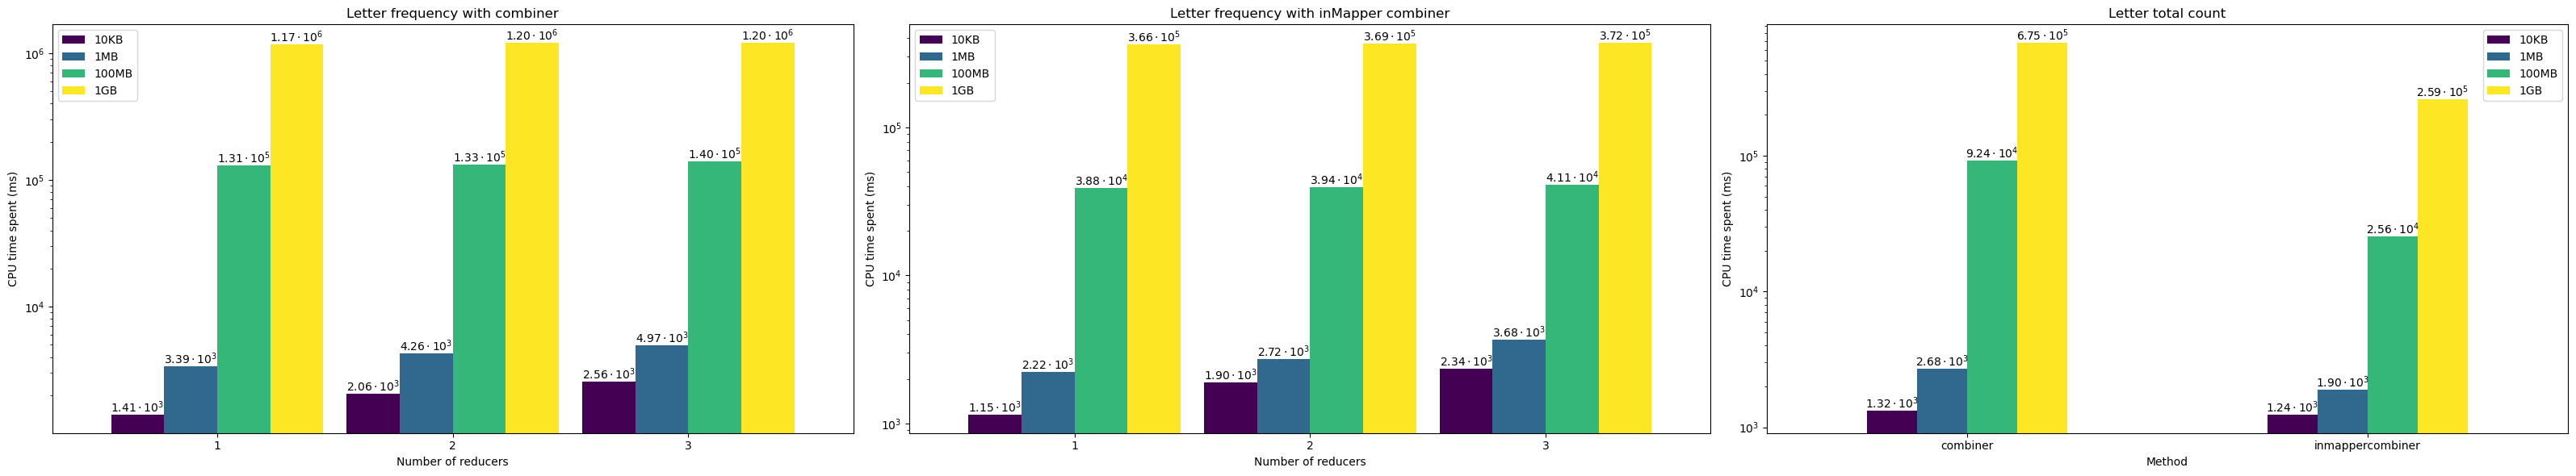

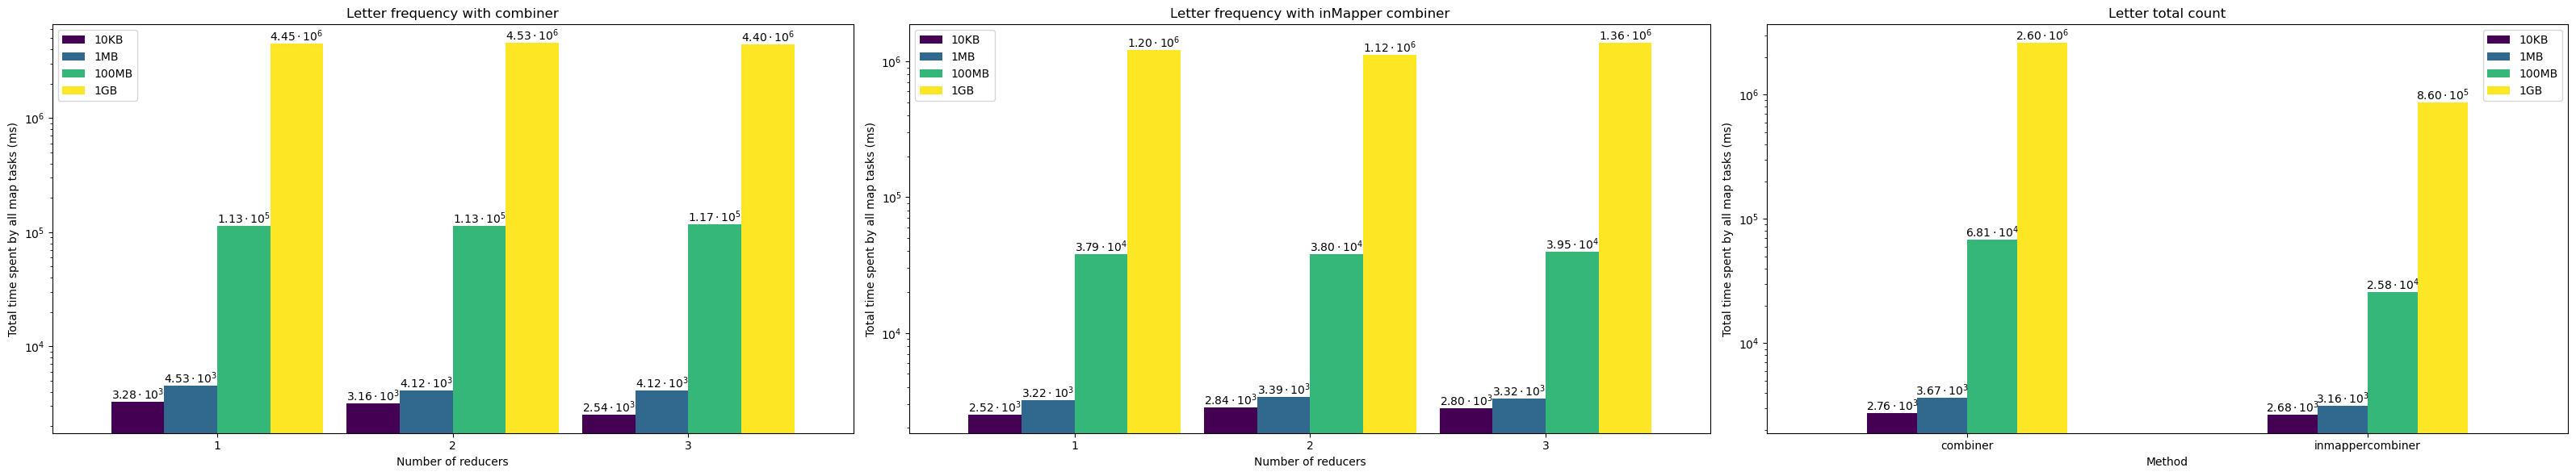

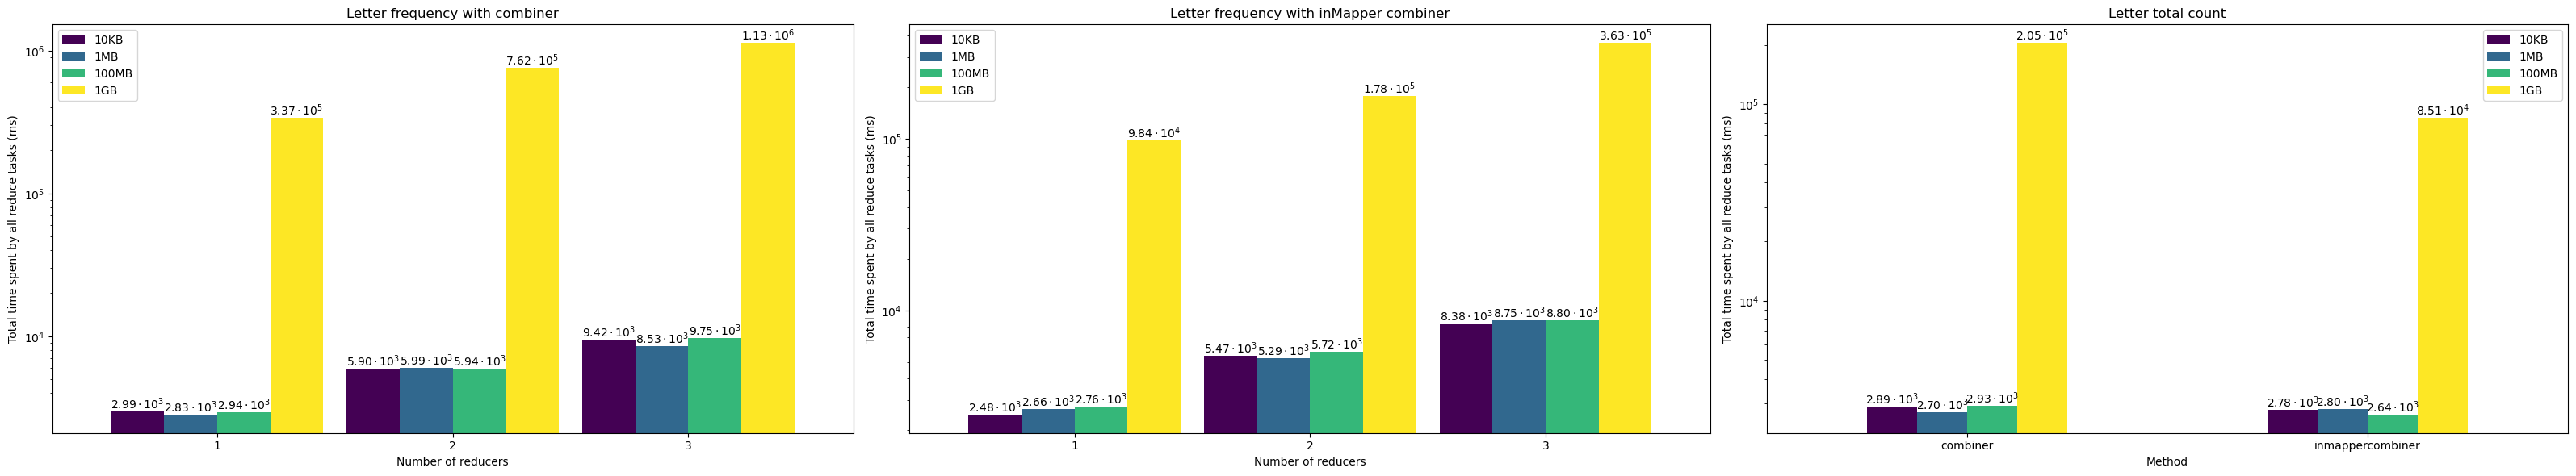

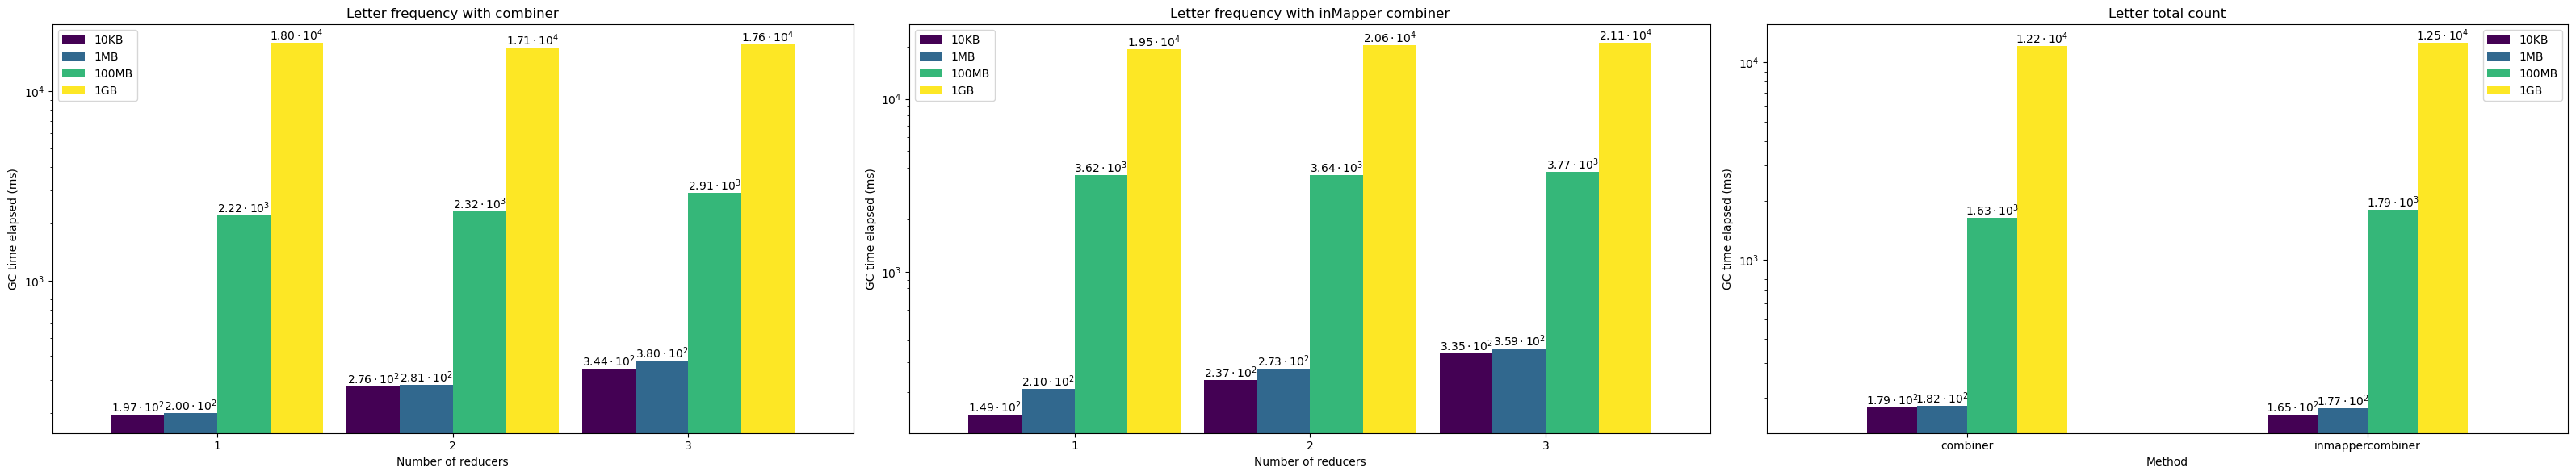

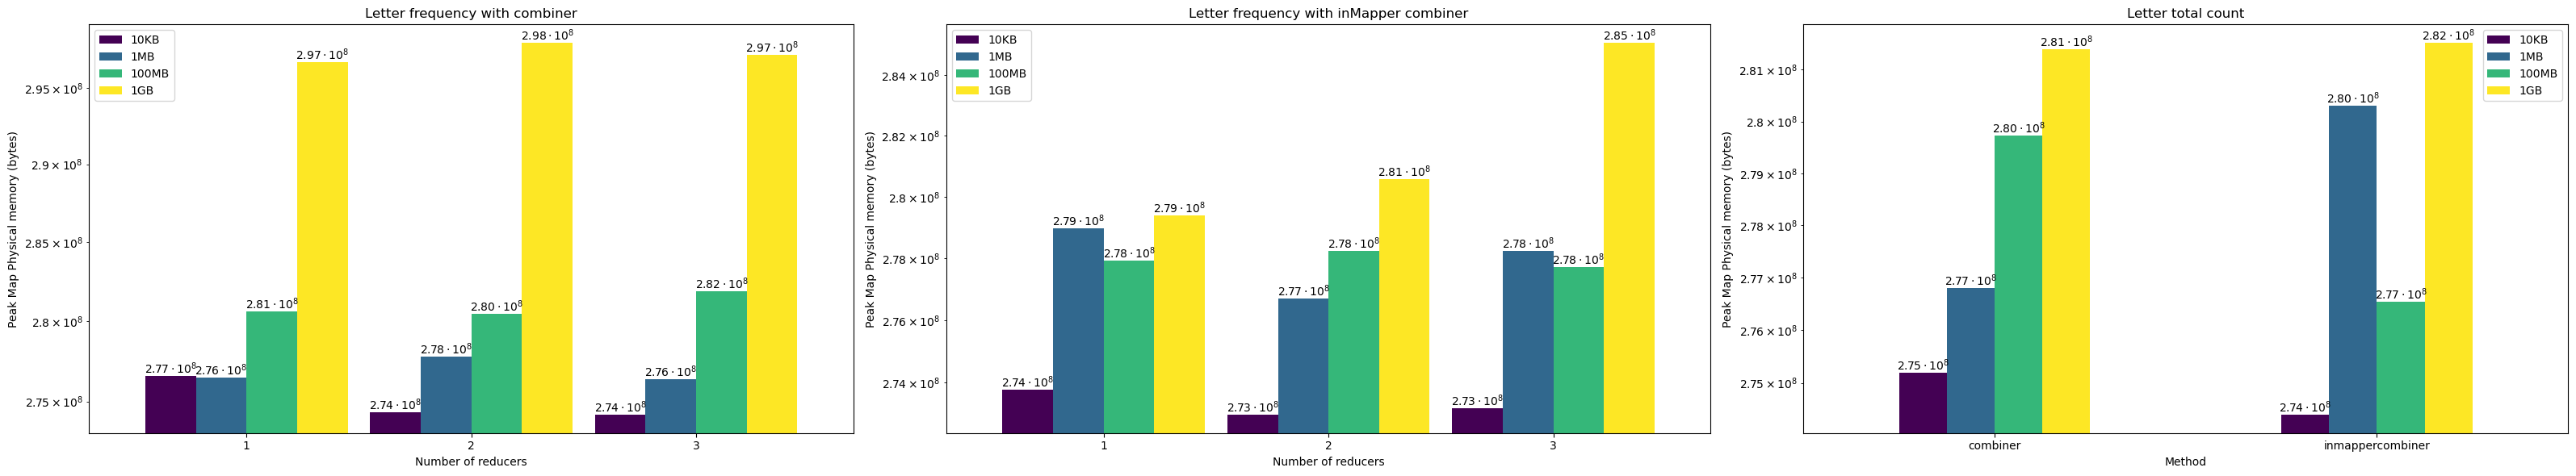

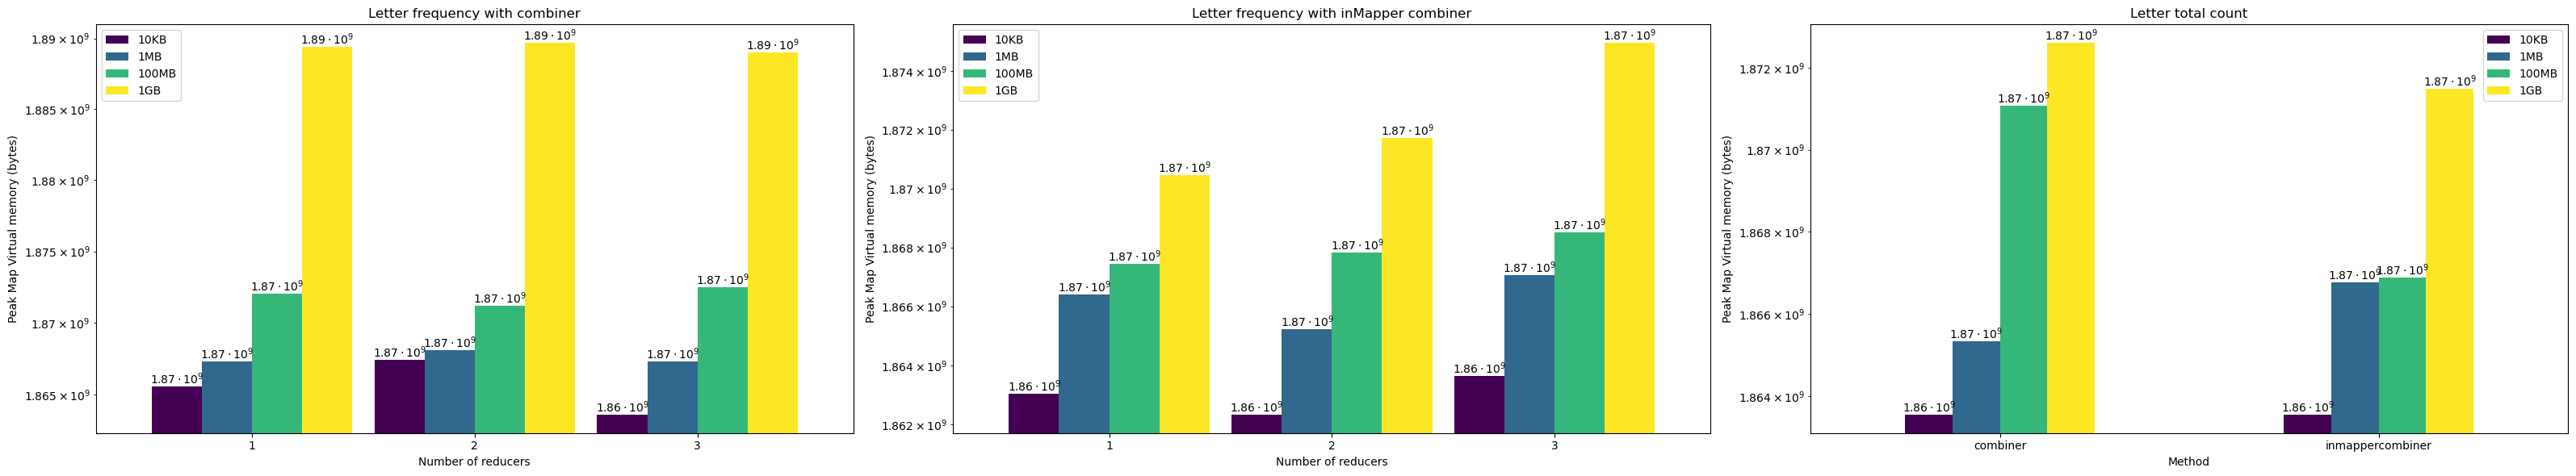

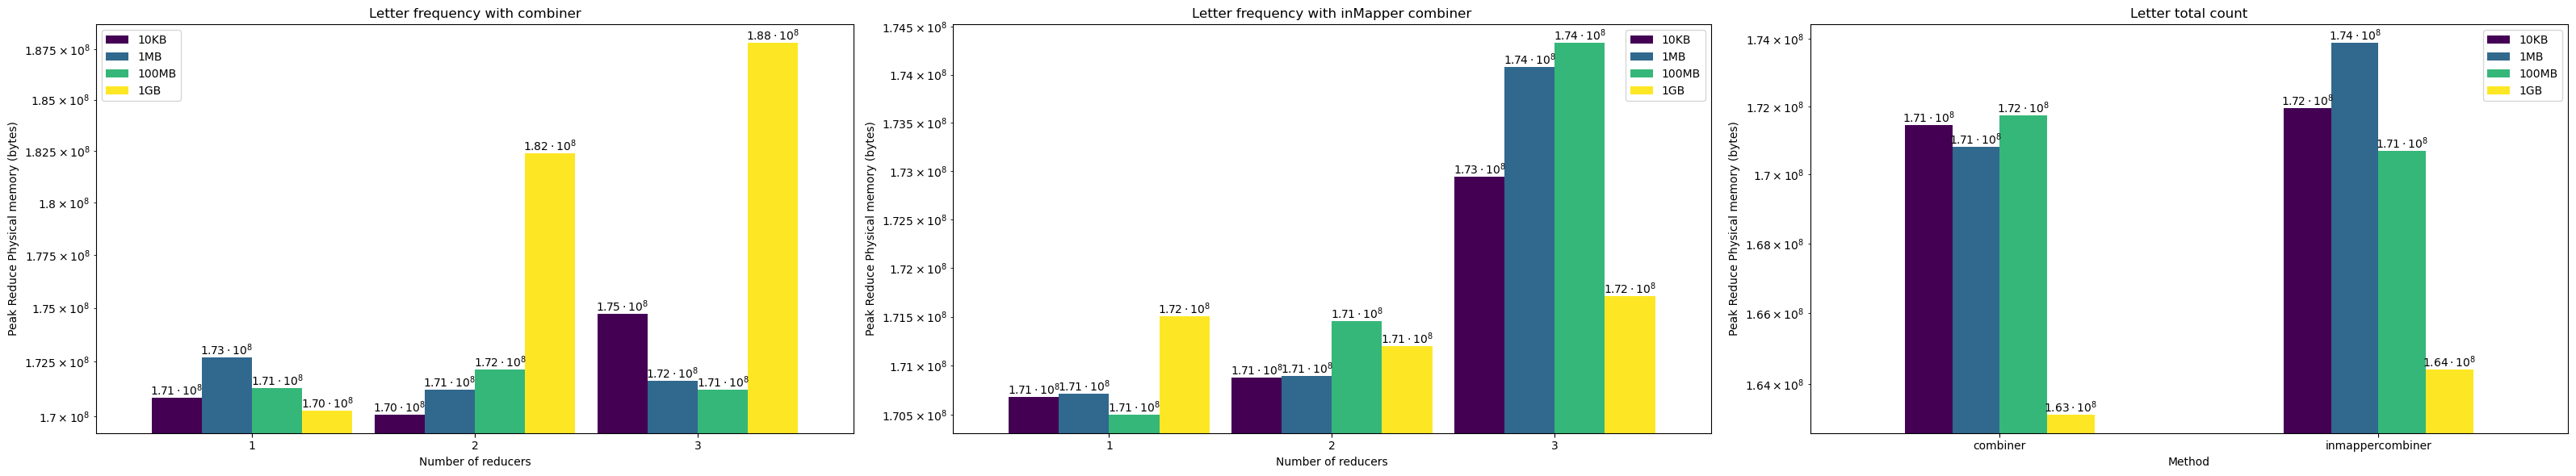

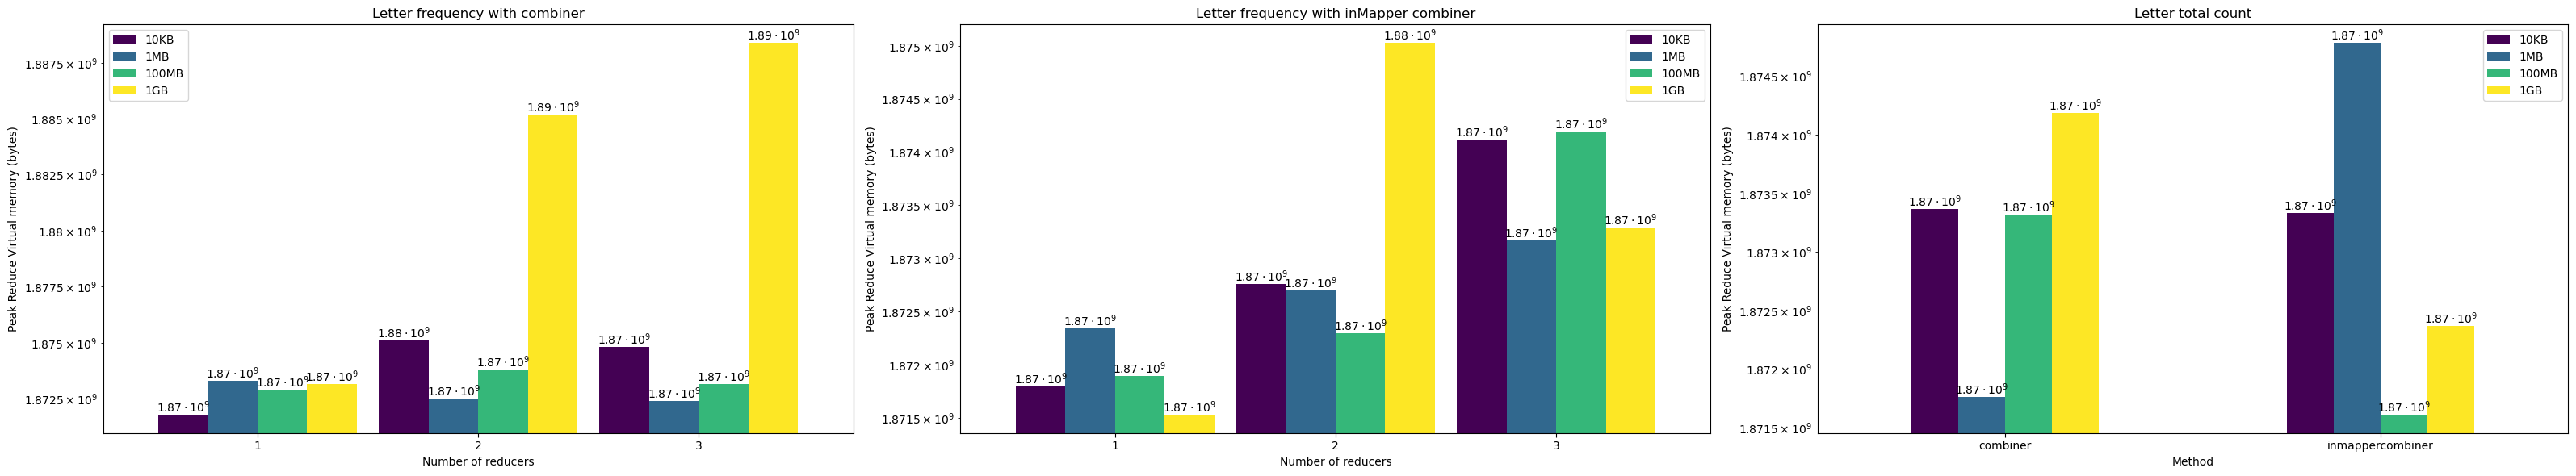

In [74]:
parameters_list = [
    'CPU time spent (ms)', 
    'Total time spent by all map tasks (ms)',
    'Total time spent by all reduce tasks (ms)',
    'GC time elapsed (ms)',
    'Peak Map Physical memory (bytes)',
	'Peak Map Virtual memory (bytes)',
	'Peak Reduce Physical memory (bytes)',
	'Peak Reduce Virtual memory (bytes)',
    ]
dim = ['10KB', '1MB', '100MB', '1GB']

for params in parameters_list:
    freq_comb_df = pd.DataFrame(index=range(1, n_reducers+1), columns=dim)
    freq_inmap_df = pd.DataFrame(index=range(1, n_reducers+1), columns=dim)
    count_df = pd.DataFrame(index=methods, columns=dim)
    count_df = count_df.fillna(0)
    for method in methods:
        for i in range(1, n_reducers+1):
            for dim_directory in os.listdir(f'../resources/performance_analysis/output_{run_id}_{method}_{i}'):
                log_file = f'../resources/performance_analysis/output_{run_id}_{method}_{i}/{dim_directory}/log.txt'
                is_total_count = True
                with open(log_file, 'r') as f:
                    for line in f:
                        if params in line:
                            if is_total_count:
                                count_df.loc[method, dim_directory] += float(line.split('=')[1])
                                is_total_count = False
                            else:
                                if method == 'combiner':
                                    freq_comb_df.loc[i, dim_directory] = float(line.split('=')[1])
                                else:
                                    freq_inmap_df.loc[i, dim_directory] = float(line.split('=')[1])
                                is_total_count = True           
    count_df = count_df / n_reducers

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3)

    freq_comb_df.plot(kind='bar', title='Letter frequency with combiner', xlabel="Number of reducers", ylabel=f'{params}', rot=0, ax=ax1, colormap='viridis', width=0.9)
    ax1.set_yscale('log')
    for p in ax1.patches:
        coeff, exponent = '{:.2e}'.format(p.get_height()).split('e')
        ax1.annotate(fr'${float(coeff):.2f} \cdot 10^{int(exponent)}$', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    freq_inmap_df.plot(kind='bar', title='Letter frequency with inMapper combiner', figsize=(32, 6), xlabel="Number of reducers", ylabel=f'{params}', rot=0, ax=ax2, colormap='viridis', width=0.9)
    ax2.set_yscale('log')
    for p in ax2.patches:
        coeff, exponent = '{:.2e}'.format(p.get_height()).split('e')
        ax2.annotate(fr'${float(coeff):.2f} \cdot 10^{int(exponent)}$', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    count_df.plot(kind='bar', title='Letter total count', xlabel="Method", ylabel=f'{params}', rot=0, ax=ax3, colormap='viridis')
    ax3.set_yscale('log')
    for p in ax3.patches:
        coeff, exponent = '{:.2e}'.format(p.get_height()).split('e')
        ax3.annotate(fr'${float(coeff):.2f} \cdot 10^{int(exponent)}$', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
